In [1]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

## **N Soliton Solutions**

### **Two Soliton**

In [2]:
def kdv_two_soliton(x, t, k1, k2, phi1, phi2):
    """
    Compute the exact two-soliton solution for the KdV equation.
    """
    # Convert inputs to numpy arrays if they aren't already
    x = np.asarray(x)
    t = np.asarray(t)
    
    # Make t broadcastable with x if needed
    if t.ndim == 0:
        t = t * np.ones_like(x)
    
    # Calculate interaction coefficient A_12
    A_12 = ((k1 - k2) / (k1 + k2))**2
    
    # Calculate Theta terms (equation 2.8)
    Theta1 = (k1 * x) - (4 * k1**3 * t) + phi1
    Theta2 = (k2 * x) - (4 * k2**3 * t) + phi2
    
    # Create exp terms for readability
    E1 = np.exp(2*Theta1)
    E2 = np.exp(2*Theta2)
    E12 = np.exp(2*Theta1 + 2*Theta2)
    
    # Calculate F^(2) (equation 2.7)
    F = 1 + E1 + E2 + A_12*E12
    
    # Calculate derivatives of F with respect to x using autograd in pytorch
    # First derivative
    dF_dx = 2*k1*E1 + 2*k2*E2 + 2*(k1+k2)*A_12*E12
    
    # Second derivative
    d2F_dx2 = 4*(k1**2)*E1 + 4*(k2**2)*E2 + 4*((k1+k2)**2)*A_12*E12
    
    
    # Calculate the solution u = 2(F''/F - (F'/F)^2)
    u = 2 * ((d2F_dx2 / F) - (dF_dx / F)**2)
    
    return u

In [3]:
def kdv_one_soliton(x, t, k, phi):

    # Calculate Theta term
    argument = (k*x) - (4*(k**3) * t) + phi
    
    # Calculate solution
    u = 2 * (k**2) * np.power(1 / np.cosh(argument), 2)
    
    return u


def twosoliton_linear_comb(x, t, k1, k2, phi1, phi2):
    # Calculate individual one-soliton solutions
    u1 = kdv_one_soliton(x, t, k1, phi1)
    u2 = kdv_one_soliton(x, t, k2, phi2)
    
    # Linear combination
    u_lin = u1 + u2
    
    return u_lin

def compare_two_soliton_sols(x, t, k1, k2, phi1, phi2):

    # Compute exact two-soliton solution
    u_exact = kdv_two_soliton(x, t, k1, k2, phi1, phi2)
    
    # Compute linear combination
    u_linear = twosoliton_linear_comb(x, t, k1, k2, phi1, phi2)
        
    return u_exact, u_linear

Parameters used:
k1 = 0.8986 (speed c1 = 3.2300)
k2 = 0.3536 (speed c2 = 0.5000)
phi1 = 29.5, phi2 = -11


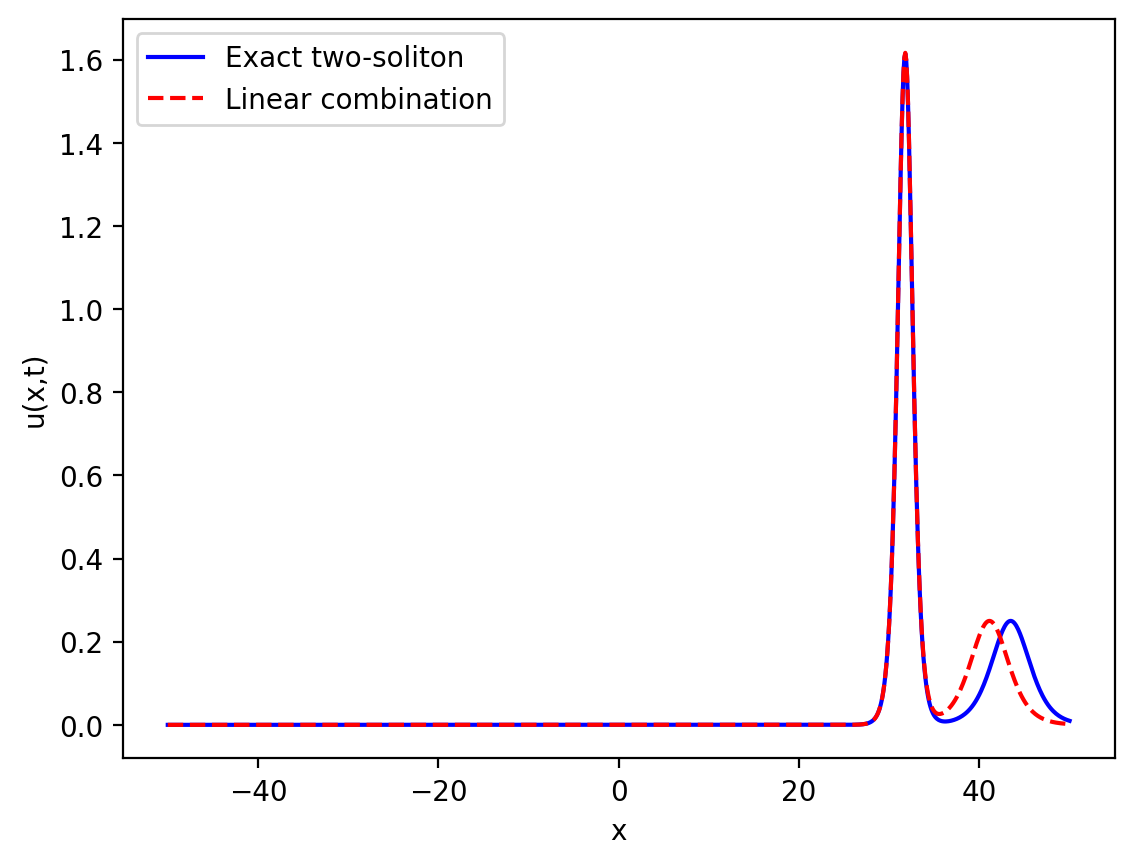

In [4]:
# Create spatial grid
x = np.linspace(-50, 50, 1000)

# Define time points to check
t = 20

# Use k values calculated from Nadia's speeds
k1 = np.sqrt(3.23/4)  # ≈ 0.9
k2 = np.sqrt(0.5/4)   # ≈ 0.354

phi1 = 29.5
phi2 = -11

print(f"Parameters used:")
print(f"k1 = {k1:.4f} (speed c1 = {4*k1**2:.4f})")
print(f"k2 = {k2:.4f} (speed c2 = {4*k2**2:.4f})")
print(f"phi1 = {phi1}, phi2 = {phi2}")

u_exact, u_linear = compare_two_soliton_sols(x, t, k1=k1, k2=k2, phi1=phi1, phi2=phi2)
plt.plot(x, u_exact, 'b-', label='Exact two-soliton')
plt.plot(x, u_linear, 'r--', label='Linear combination')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.show()

Max absolute PDE residual: 32.840097533252745


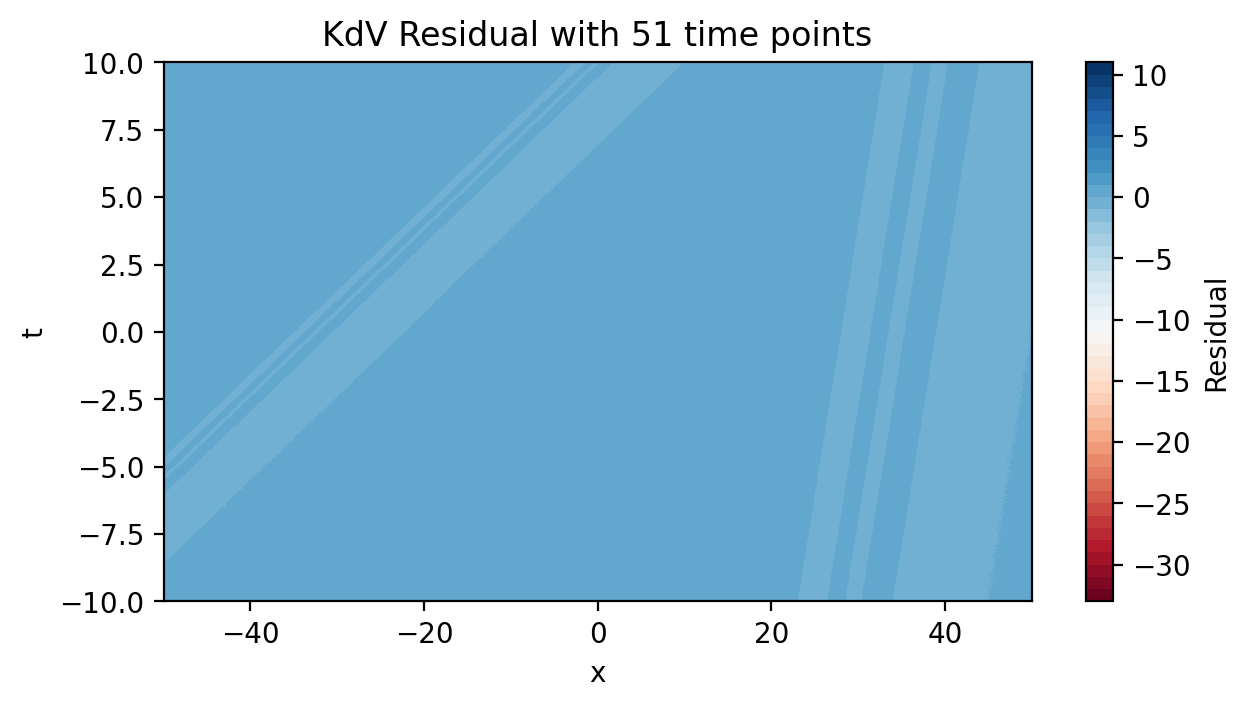

In [5]:
def kdv_two_soliton(x, t, k1, k2, phi1, phi2):
    x = np.asarray(x)
    t = np.asarray(t)
    if t.ndim == 0:
        t = t * np.ones_like(x)
    
    A_12 = ((k1 - k2) / (k1 + k2))**2
    Theta1 = k1*x - 4*(k1**3)*t + phi1
    Theta2 = k2*x - 4*(k2**3)*t + phi2
    
    E1 = np.exp(2*Theta1)
    E2 = np.exp(2*Theta2)
    E12 = np.exp(2*Theta1 + 2*Theta2)
    
    F = 1 + E1 + E2 + A_12*E12
    dFdx = 2*k1*E1 + 2*k2*E2 + 2*(k1+k2)*A_12*E12
    d2Fdx2 = 4*k1**2*E1 + 4*k2**2*E2 + 4*(k1+k2)**2*A_12*E12
    
    u = 2*((d2Fdx2/F) - (dFdx/F)**2)
    return u

# Spatial grid
x = np.linspace(-50, 50, 5000)
# Much finer time grid
t = np.linspace(-10, 10, 5000)  # 51 points in time

T, X = np.meshgrid(t, x, indexing='ij')

k1 = np.sqrt(3.23/4)  # ~0.9
k2 = np.sqrt(0.5/4)   # ~0.354
phi1, phi2 = 29.5, -11

u = kdv_two_soliton(X, T, k1, k2, phi1, phi2)

dx = x[1] - x[0]
dt = t[1] - t[0]

# Numerically approximate derivatives
u_t = np.gradient(u, dt, axis=0)
u_x = np.gradient(u, dx, axis=1)
u_xx = np.gradient(u_x, dx, axis=1)
u_xxx = np.gradient(u_xx, dx, axis=1)

residual = u_t + 6*u*u_x + u_xxx

max_res = np.max(np.abs(residual))
print("Max absolute PDE residual:", max_res)

plt.figure(figsize=(7, 3.5))
plt.contourf(X, T, residual, levels=50, cmap='RdBu')
plt.colorbar(label='Residual')
plt.xlabel('x')
plt.ylabel('t')
plt.title('KdV Residual with 51 time points')
plt.show()

In [6]:
def kdv_two_soliton(x, t, k1, k2, delta1, delta2):
    """
    Compute the two-soliton solution of the KdV equation.
    
    The solution is based on the tau-function:
      f(x,t) = 1 + exp(eta1) + exp(eta2) + A*exp(eta1+eta2),
    where
      eta_i = k_i * x - 4*k_i^3*t + delta_i,  for i = 1,2, and
      A = ((k1 - k2)/(k1 + k2))**2.
      
    The KdV solution is given by:
      u(x,t) = 2 * (f''/f - (f'/f)**2)
      
    Parameters:
      x      : spatial coordinate (can be scalar or numpy array)
      t      : time (scalar)
      k1, k2 : soliton parameters
      delta1, delta2 : phase shifts
      
    Returns:
      u      : value(s) of the KdV two-soliton solution at x and t
    """
    # Compute the phase functions for each soliton
    eta1 = k1 * x - 4 * k1**3 * t + delta1
    eta2 = k2 * x - 4 * k2**3 * t + delta2
    
    # Compute the interaction coefficient A
    A = ((k1 - k2) / (k1 + k2))**2
    
    # Compute the tau function f and its derivatives with respect to x.
    f = 1 + np.exp(eta1) + np.exp(eta2) + A * np.exp(eta1 + eta2)
    fprime = k1 * np.exp(eta1) + k2 * np.exp(eta2) + A * (k1 + k2) * np.exp(eta1 + eta2)
    f2 = k1**2 * np.exp(eta1) + k2**2 * np.exp(eta2) + A * (k1 + k2)**2 * np.exp(eta1 + eta2)
    
    # Compute u by using u = 2*(f''/f - (f'/f)**2)
    u = 2 * (f2 / f - (fprime / f)**2)
    
    return u

In [7]:
def kdv_one_soliton(x, t, k, delta):

    # Calculate Theta term
    argument = (k*x) - (4*(k**3) * t) + delta
    
    # Calculate solution
    u = (k**2)/2 * np.power(1 / np.cosh(argument/2), 2)
    
    return u

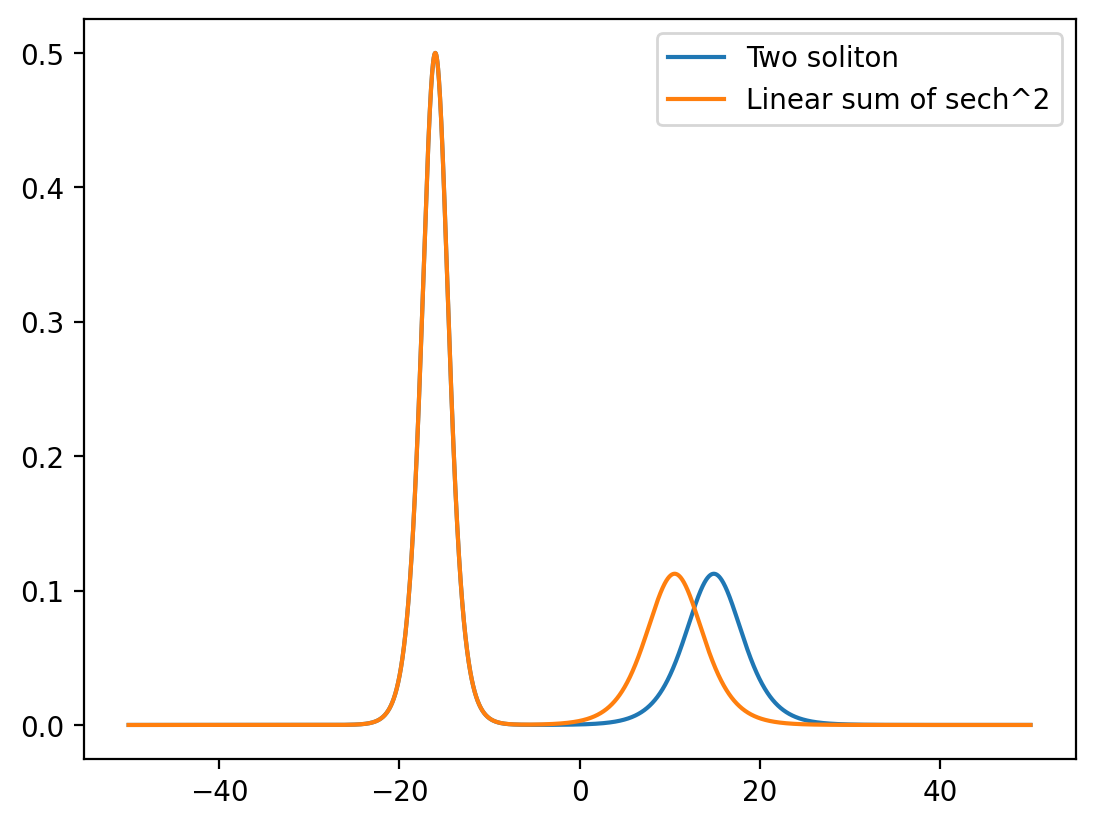

In [8]:
# compute the solution at t = 20
k1 = np.sqrt(4 / 4)  # e.g., ≈0.9
k2 = np.sqrt(0.9 / 4)   # e.g., ≈0.354
phi1 = 16
phi2 = -5


x = np.linspace(-50, 50, 5000)
t = 0

u = kdv_two_soliton(x, t, k1, k2, phi1, phi2)

u_naive = kdv_one_soliton(x, t, k1, phi1) + kdv_one_soliton(x, t, k2, phi2)

plt.plot(x, u, label='Two soliton')
plt.plot(x, u_naive, label='Linear sum of sech^2')
plt.legend()
plt.show()

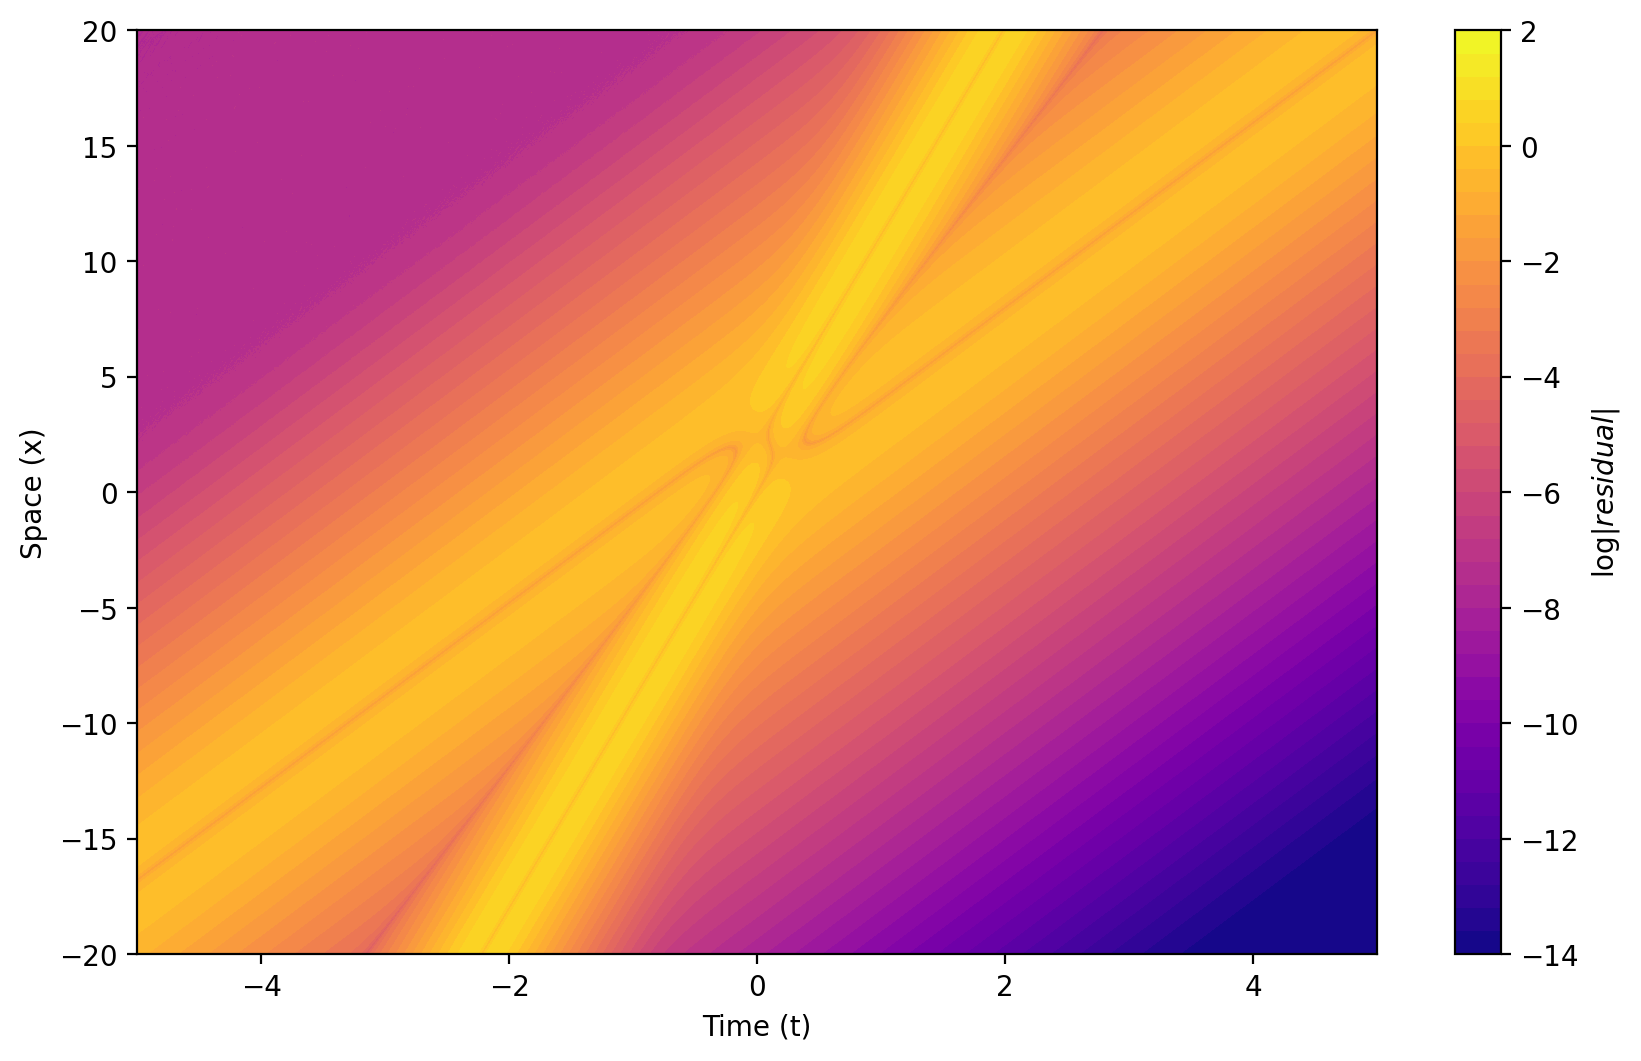

In [9]:
# Define the domain in x and t
x_min, x_max = -20, 20
t_min, t_max = -5, 5
nx, nt = 10000, 10000
x = np.linspace(x_min, x_max, nx)
t = np.linspace(t_min, t_max, nt)
X, T = np.meshgrid(x, t, indexing='ij')  # X.shape = (nx, nt) corresponds to x; T to t

# Set two-soliton parameters (example values)
k1 = 1.0
k2 = 1.5
delta1 = 0.0
delta2 = 0.0

# Compute the two-soliton solution u(x,t)
U = kdv_two_soliton(X, T, k1, k2, delta1, delta2)

# Compute grid spacings for finite differences
dx = (x_max - x_min) / (nx - 1)
dt = (t_max - t_min) / (nt - 1)

# Calculate derivatives using numpy's gradient
# u_x : derivative of u with respect to x (axis=0)
u_x = np.gradient(U, dx, axis=0)

# u_t : derivative of u with respect to time (axis=1)
u_t = np.gradient(U, dt, axis=1)
# u_xx : second derivative with respect to x
u_xx = np.gradient(u_x, dx, axis=0)
# u_xxx : third derivative with respect to x
u_xxx = np.gradient(u_xx, dx, axis=0)

# Compute the residual of the KdV equation: u_t + 6*u*u_x + u_xxx = 0
residual = u_t + 6 * U * u_x + u_xxx

# For clarity in plotting, take the logarithm (base 10) of the absolute residual.
log_residual = np.log10(np.abs(residual) + 1e-14)

# Create a contour plot of the residual on a log scale
plt.figure(figsize=(10, 6))
contour = plt.contourf(T, X, log_residual, levels=50, cmap='plasma')
plt.colorbar(contour, label=r'$\log|residual|$')
plt.xlabel('Time (t)')
plt.ylabel('Space (x)')
plt.show()

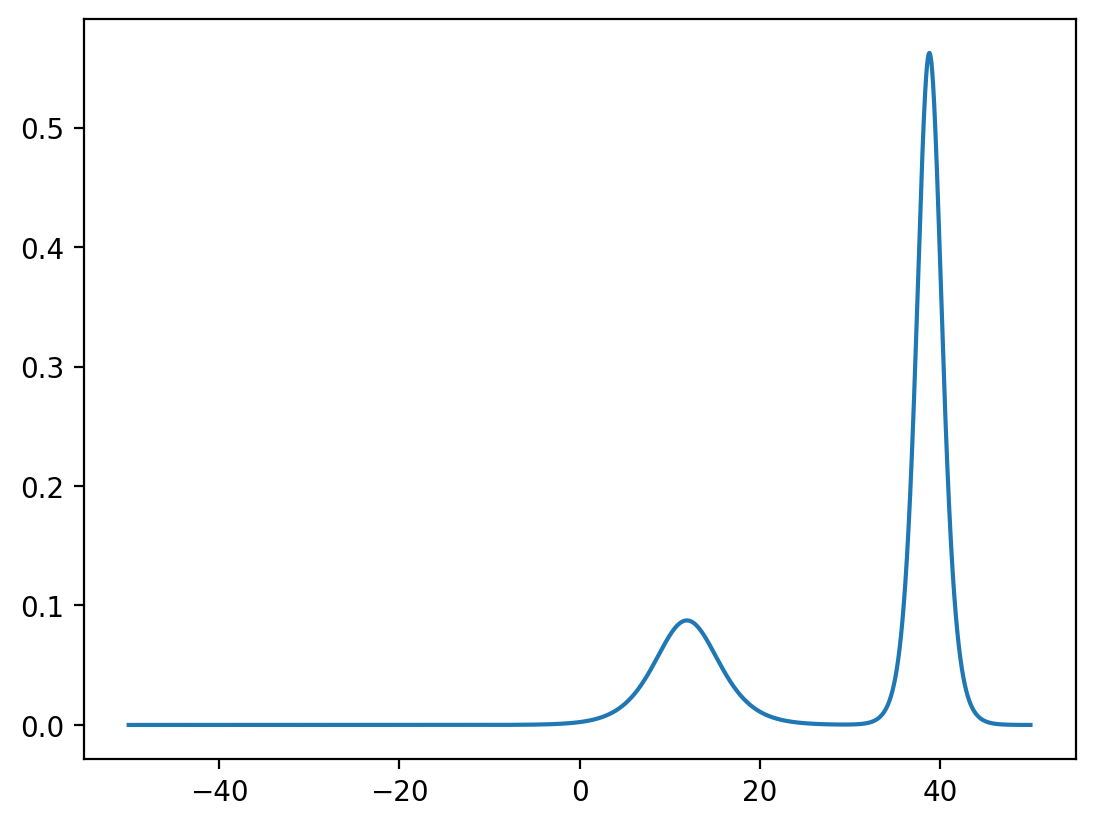

In [80]:
k1 = np.sqrt(4.5/4)  # First wavenumber (c₁ = 3.23)
k2 = np.sqrt(0.7/4)  # Second wavenumber (c₂ = 0.5)
phi1 = 40  # First phase
phi2 = 0   # Second phase

t = 17
x = np.linspace(-50, 50, 5000)
u_naive = kdv_one_soliton(x, t, k1, phi1) + kdv_one_soliton(x, t, k2, phi2)

plt.plot(x, u_naive)